In [1]:
from awrams.calibration.support import *
from os.path import join
from awrams.utils import gis
from awrams.utils import datetools as dt
from awrams.utils import extents
from awrams.utils.settings_manager import get_settings
import h5py

In [2]:
# Point to the data

CATCH_PATH = '/mnt/awramsi_test_data/Catchments/'

In [3]:
#paths = get_settings('data_paths')

cal_extents = join(CATCH_PATH,'calibration_extents_5k.nc')
nces = gis.ExtentStoreNC(cal_extents,'r')

catch_list_fn = join(CATCH_PATH,'Catchment_IDs.csv')


catch_df = open(catch_list_fn).readlines()
cids = [k.strip().zfill(6) for k in catch_df[1:]]

In [4]:
extent_map = dict([(e,nces[e]) for e in cids[4:7]])
extent_map

{'109001': origin: -16.4,145.2, shape: (3, 5), cell_size: 0.05,
 '111101': origin: -17.35,145.7, shape: (4, 8), cell_size: 0.05,
 '112102': origin: -17.65,145.8, shape: (4, 3), cell_size: 0.05}

In [5]:
run_period = dt.dates('2010 - 2013')
eval_period = dt.dates('2010 - 2013')

# Use the SobolOptimizer class to generate Sobol sequence samples

from awrams.calibration.sensitivity import SobolOptimizer

optimizer_spec = OptimizerSpec(SobolOptimizer,threshold = 0.01,max_eval = 3000)

from awrams.calibration.objectives import test_objectives as tobj


# Our 'objective functions' (ie what gets stored in the logfile)
# are volume totals of water balance outputs; runoff, et, and deep drainage

local_objfspec = ObjectiveFunctionSpec(tobj.LocalQTotal)
global_objfspec = tobj.GlobalQTotal

observations = {}

objective_spec = ObjectiveSpec(global_objfspec,local_objfspec,observations,eval_period)

# Import awral


from awrams.models import awral
from awrams.utils.nodegraph import nodes, graph
node_mapping = awral.get_default_mapping()['mapping']
#model = callable_to_funcspec(awral)
model = awral

from awrams.models.settings import CLIMATOLOGY

node_mapping['solar_clim'] = nodes.monthly_climatology(*CLIMATOLOGY['solar'])
node_mapping['solar_filled'] = nodes.gap_filler('solar_f','solar_clim')
node_mapping['rgt'].inputs[0] = 'solar_filled'


In [6]:
# Inspect the mapping to get all keys for forcing data

forcing_nodes = [k for k,v in node_mapping.items() if v.node_type == 'forcing_from_ncfiles']
forcing_nodes

['tmax_f', 'solar_f', 'tmin_f', 'precip_f']

In [7]:
# Update the paths to forcing data - usually this is obtained from config files, but we're making it explicit here

AWAP_PATH = "/mnt/awramsi_test_data/AWAP_4_Years/"

for k in forcing_nodes:
    n = node_mapping[k]
    n.path = AWAP_PATH
    n.pattern = "%s*.nc" % k

#Build spec dict

Assemble above settings into specification dictionary

In [8]:
'''
User specifiable calibration description
'''
cal_spec = {}
cal_spec['optimizer_spec'] = optimizer_spec
cal_spec['objective_spec'] = objective_spec
cal_spec['extent_map'] = extent_map
cal_spec['run_period'] = run_period
cal_spec['model'] = model
cal_spec['node_mapping'] = node_mapping
#cal_spec['logfile'] = '/short/er4/dss548/calibration_res.h5'
cal_spec['logfile'] = './sobolres4.h5'

#cal_spec['prerun_action'] = callable_to_funcspec(prerun_raijin)
#cal_spec['postrun_action'] = callable_to_funcspec(postrun_raijin)



In [9]:
from awrams.calibration import cluster
_ = cluster.build_pickle_from_spec(cal_spec,1,'test_sens.pkl')

In [10]:
from awrams.calibration.launch_calibration import run_from_pickle
run_from_pickle('./test_sens.pkl')

s:  2905
n
[('sample_space', <class 'str'>), ('ss_iter', <class 'int'>)]

 launching
{}
..................
 running
{'cur_sens': 6.7085403917799655e+22, 'n_eval': 115}

 running
{'cur_sens': 4.7871311501004425e+25, 'n_eval': 230}

 running
{'cur_sens': 7.3797551477545472e+25, 'n_eval': 460}

 running
{'cur_sens': 8.3808209604520042e+25, 'n_eval': 805}

 running
{'cur_sens': 8.7490777472016284e+25, 'n_eval': 1035}

 running
{'cur_sens': 9.1099321910804602e+25, 'n_eval': 1265}

 running
{'cur_sens': 9.6546863072686298e+25, 'n_eval': 1610}

 running
{'cur_sens': 1.0076204160633733e+26, 'n_eval': 1840}

 running
{'cur_sens': 1.0370814170917262e+26, 'n_eval': 2070}

 running
{'cur_sens': 1.0616121177900242e+26, 'n_eval': 2185}
.
 running
{'cur_sens': 1.100960045447069e+26, 'n_eval': 2415}

 running
{'cur_sens': 1.049838190257574e+26, 'n_eval': 2645}

 running
{'cur_sens': 1.03625143429543e+26, 'n_eval': 2875}

 running
{'cur_sens': 1.0391859171336019e+26, 'n_eval': 2990}
/home/dshipman/WGIT

In [11]:
from awrams.calibration import sensitivity
from collections import OrderedDict
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (6,10)
from awrams.calibration.sensitivity import SensitivityResults

In [12]:
sr = SensitivityResults('./sobolres4.h5')

In [13]:
sr.global_keys

['dd_vol', 'etot_vol', 'qtot_vol']

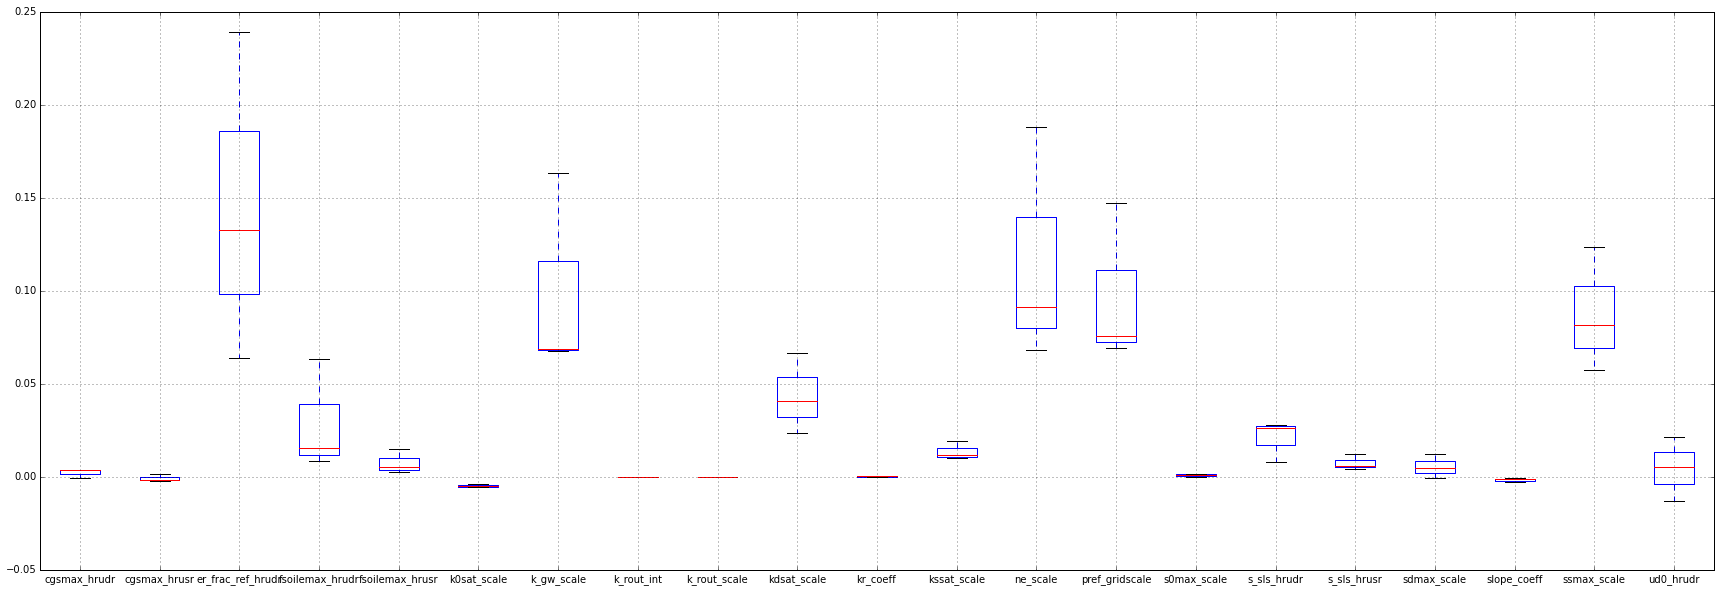

In [14]:
catchsens = sr.get_all_catchment_si('qtot_vol')
fig = plt.figure(figsize=(30,10))
bp = catchsens.astype(float).boxplot(return_type='axes')

In [15]:
def plot_si(sr,param,catchment=None):
    fig = plt.figure(figsize=(6,10))
    if catchment is not None:
        psens = sr.get_catchment_si(param,catchment)
        title = '%s (Si), catch_id: %s' % (param, catchment)
    else:
        psens = sr.get_global_si(param)
        title = '%s (Si), global' % param
    psens.plot(kind='barh',xlim=[0,psens.max()+0.1],title=title)
    plt.gca().invert_yaxis()
    print(sum(psens))

In [16]:
def plot_sti(sr,param,catchment=None):
    fig = plt.figure(figsize=(6,10))
    if catchment is not None:
        psens = sr.get_catchment_si(param,catchment,True)
        title = '%s (STi), catch_id: %s' % (param, catchment)
    else:
        psens = sr.get_global_si(param,True)
        title = '%s (STi), global' % param
    psens.plot(kind='barh',xlim=[0,psens.max()+0.1],title=title)
    plt.gca().invert_yaxis()
    print(sum(psens))

1.07608645758


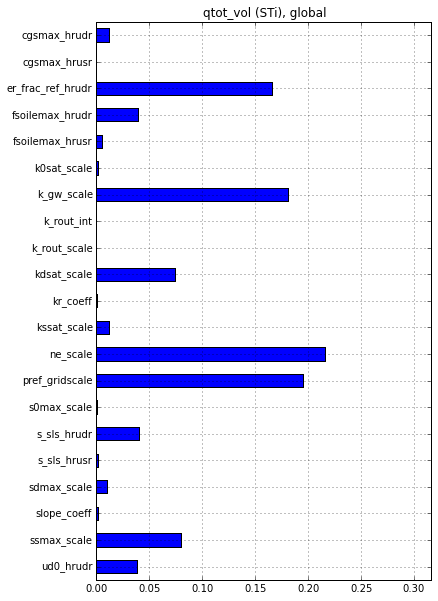

In [22]:
plot_sti(sr,'qtot_vol')

1.07839898685


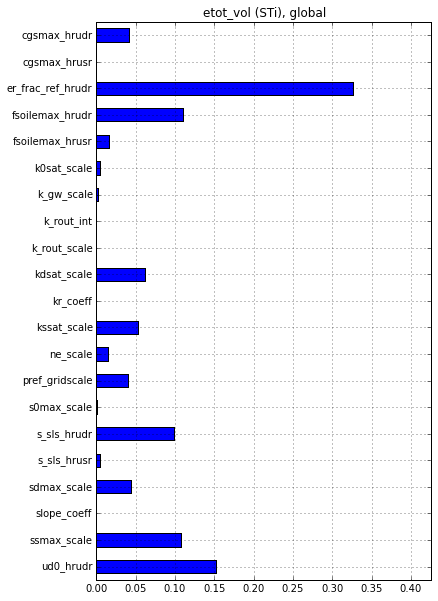

In [18]:
plot_sti(sr,'etot_vol')

1.13300201589


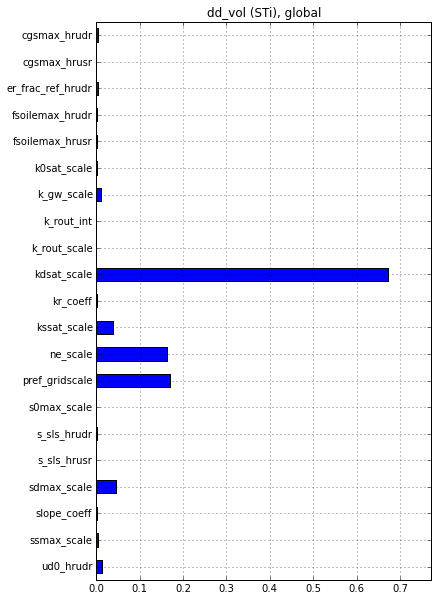

In [19]:
plot_sti(sr,'dd_vol')

In [20]:
sr.ds.close()